<font size="5"> This notebook loads the weights of the pre-trained model on synthetic data and performs Fine Tuning by re-training on new real data <font size>

Note : Part 1, 5.1 and 5.3 need the data that are too heavy to load on the github, which is the data used to train the first CNN on synthetic data, and a .fits image

In [1]:
import numpy as np 
import os
import gc
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.utils import class_weight
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from utils.tools import * 

### 1. Loading the Train Data of the CNN

In [2]:
#We here load the data containing synthetic images on which we trained the CNN. The data is too heavy to be loaded 
#On Github
datapath = 'CNN_trainingSet/'
x_train1 = np.load(datapath + 'X_train.npy', allow_pickle = True)
y_train1 = np.load(datapath + 'Y_train.npy', allow_pickle = True)

### 2 UNET ARCHITECTURE

In [3]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 32, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-5, verbose=1),
]


def jaccard_distance(y_true, y_pred):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + 100.) / (sum_ - intersection + 100.)
    jd =  (1 - jac) * 100.
    return tf.reduce_mean(jd)


In [4]:
 def load_model(learning_rate, dropout,i):
        """
        This functions loads the checkpoints of the CNN after training on synthetic data, and blocks
        some layers depending on which case
        """
        im_height = 256
        im_width = 256
        input_img = Input((im_height, im_width, 1), name='img')
        model = get_unet(input_img, n_filters= 32, dropout=dropout, batchnorm=True)
        model.compile(optimizer=Adam(lr =learning_rate), loss="binary_crossentropy", metrics=[jaccard_distance])
        model.load_weights('model1')
     
        # depend on the values of i, block some layers
        index = 0
        for layer in model.layers : 
            index += 1
            #print(index,layer.name)
            if i == 1 : 
                if index == 46 or index == 49 : 
                    layer.trainable = True
                else : 
                    layer.trainable = False
            elif i == 2 : 
                if index == 49 : 
            #if index == 46 or index == 49 or index == 40:  
                    layer.trainable = True
                else : 
                    layer.trainable = False
            
        return model 


### 3. Load Model1 

In [5]:
""" Real Data containing Satellites"""
X_vraie = np.load('FineTuningData/X.npy')
Y_vraie = np.load('FineTuningData/Y.npy')

The table results contains values in the following order : <br> 
i, Epoch, LR, Dropout, Treshold, Dice+ std, Accuracy + std, Recall + std, specificity + std, precision + std, NPV + std <br>
i = 0 => no layers frozen <br>
i = 1 => last 2 layers unfrozen <br>
i = 2 => last layers unfrozen

In [6]:
"""Best Parameters found"""
results = np.load('FineTuningData/Fine_Tuning_Parameters.npy')
results[np.argmax(results[:,5],axis=0),:]

array([1.00000000e+00, 6.00000000e+01, 1.00000000e-02, 2.00000000e-01,
       1.50000000e-01, 5.84561657e-01, 2.73908954e-02, 9.97261047e-01,
       4.50649434e-04, 6.15057290e-01, 3.30240904e-02, 9.98728524e-01,
       4.25749187e-04, 6.51139751e-01, 1.03344447e-01, 9.98520435e-01,
       3.47762489e-04, 4.00000000e+00])

In [7]:
""" Load Model 1"""
import random
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

learning_rate = 1e-2
dropout = 0.2
i = 1
treshold = 0.15
tf.keras.backend.clear_session()
model1 = load_model( learning_rate, dropout, 0)

### Data Augmentation and creating Train/Test Set

In [8]:
#Random Shuffle and train model2 with Fine Tuning
X_shuf, Y_shuf = shuffle_in_unison(X_vraie, Y_vraie,123456789)

In [9]:
#Separate into Train/Test
X_train = X_shuf[0:14,:,:] ; Y_train = Y_shuf[0:14,:,:]
X_test = X_shuf[14:,:,:]   ; Y_test =  Y_shuf[14:,:,:]

In [10]:
#Perform some random transformations on the train data
import cv2
from matplotlib import pyplot as plt
import albumentations as A

transform = A.Compose(
    [
    A.VerticalFlip(p=0.8),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.6),
    ],
    additional_targets={'image0': 'image'}
)

for i in range(14) : 
    for j in range(np.random.randint(2)+1) :
        transformed = transform(image=X_train[i,:,:], image0=Y_train[i,:,:])
        im1 = np.reshape(transformed['image'], newshape = (1,256,256)); 
        im2 = np.reshape(transformed['image0'], newshape = (1, 256, 256)); 
        #X_vraie = np.vstack((X_vraie, im1))
        X_train = np.append(X_train, im1, axis = 0)
        Y_train = np.append(Y_train, im2, axis = 0 )


### Train the model 2 from previous checkpoints with Fine Tuning, and save the model

In [11]:
# This part performs the new training on the new model where we block layers
# We have already trained it and save the weights of the resulting model
""""
model2 = load_model( learning_rate, dropout, 1)
model2.fit(X_train, Y_train, batch_size=5, epochs=60)
model2_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model2_json)
# serialize weights to HDF5
model2.save_weights("model2")
print("Saved model to disk")
"""

'"\nmodel2 = load_model( learning_rate, dropout, 1)\nmodel2.fit(X_train, Y_train, batch_size=5, epochs=60)\nmodel2_json = model2.to_json()\nwith open("model2.json", "w") as json_file:\n    json_file.write(model2_json)\n# serialize weights to HDF5\nmodel2.save_weights("model2")\nprint("Saved model to disk")\n'

#### Load the model 

In [12]:
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model2 = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
model2.load_weights("model2")
print("Loaded model from disk")

Loaded model from disk


In [13]:
# trainable = False for model evalution
model1.trainable = False
model2.trainable = False

### 4. Predictions

In [14]:
from matplotlib.pyplot import figure
def final_pred(prediction, treshold) : 
    prediction[prediction>treshold] = 1
    prediction[prediction<treshold] = 0
    return prediction

def prediction_train(index) : 
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(18.5, 10.5) 
    prediction1 = model1.predict(x_train1[index,:,:].reshape(1,256,256,1))
    prediction2 = model2.predict(x_train1[index,:,:].reshape(1,256,256,1))
    ax1.imshow(x_train1[index,:,:])
    ax2.imshow(y_train1[index,:,:])
    ax3.imshow(prediction1.reshape(256,256))
    ax4.imshow(prediction2.reshape(256,256))

def prediction_new(image) : 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(14.5, 9.5) 
    prediction1 = model1.predict(image.reshape(1,256,256,1))
    prediction2 = model2.predict(image.reshape(1,256,256,1))
    ax1.imshow(image)
    ax2.imshow(prediction1.reshape(256,256))
    ax3.imshow(prediction2.reshape(256,256))
def prediction_mask(image, target) : 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(14.5, 9.5) 
    prediction2 = model2.predict(image.reshape(1,256,256,1))
    ax1.imshow(image)
    ax2.imshow(target)
    ax3.imshow(final_pred(prediction2, treshold).reshape(256,256))

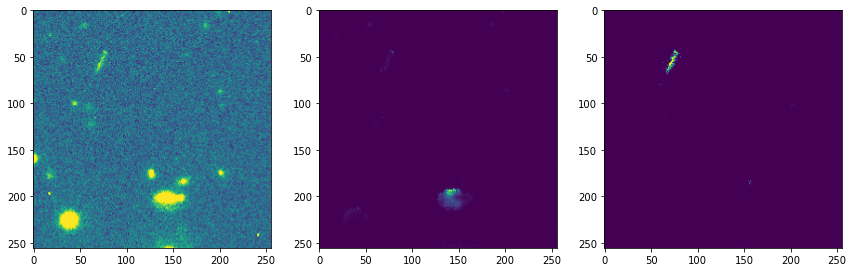

In [15]:
#Real Test Data on the left, model 1 prediction in the middle and model 2 prediction on the right
prediction_new(X_test[0,:,:])

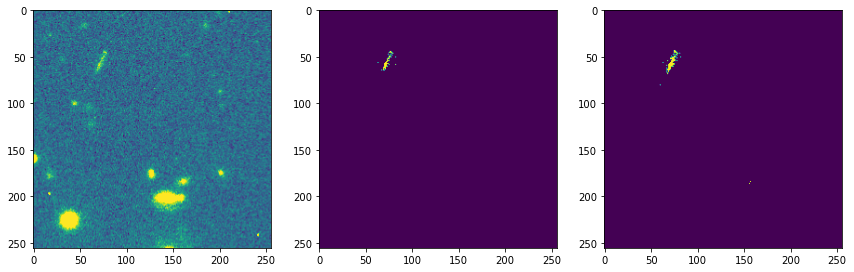

In [16]:
# Real mask in the middle, prediction with model 2 after tresholding on the right
prediction_mask(X_test[0,:,:], Y_test[0,:,:])

### 5. Comparing model 1 and model 2

###  5.1 Results on test set

In [17]:
#Average prediction results on test
#1 refers to model1, without Fine Tuning
#2 refers to mdoel2, with Fine Tuning
Dices_1 = [] ; Accuracy1 = [] ; Recall1 = [] ; Spe1 = [] ; Precision1 = []
Dices_2 = [] ; Accuracy2 = [] ; Recall2 = [] ; Spe2 = [] ; Precision2 = []
for i in range(np.shape(X_test)[0]) : 
    pred1 =  final_pred(model1.predict(X_test[i,:,:].reshape(1,256,256,1)), treshold).reshape((256,256))
    pred2 =  final_pred(model2.predict(X_test[i,:,:].reshape(1,256,256,1)), treshold).reshape((256,256)) 
    dice, acc, rec, spe, prec, _ = Metrics(pred1, Y_test[i,:,:])
    Dices_1.append(dice);Accuracy1.append(acc);Recall1.append(rec);Spe1.append(spe);Precision1.append(prec)
    dice, acc, rec, spe, prec, _ = Metrics(pred2, Y_test[i,:,:])
    Dices_2.append(dice);Accuracy2.append(acc);Recall2.append(rec);Spe2.append(spe);Precision2.append(prec)
np_Dices1 = np.array(Dices_1) ; np_Acc1 = np.array(Accuracy1) ; np_Rec1 = np.array(Recall1) ; np_Spe1 = np.array(Spe1)
np_Prec1 = np.array(Precision1)
np_Dices2 = np.array(Dices_2) ; np_Acc2 = np.array(Accuracy2) ; np_Rec2 = np.array(Recall2) ; np_Spe2 = np.array(Spe2)
np_Prec2 = np.array(Precision2)

In [18]:
""""Print the results """
data = {'Models' : [1,2] , 
        'Dice index' : [np.mean(np_Dices1), np.mean(np_Dices2)], 'Dice std' : [np.std(np_Dices1), np.std(np_Dices2)], 
        'Accuracy' : [np.mean(np_Acc1), np.mean(np_Acc2)],       'Accuracy std' : [np.std(np_Acc1), np.std(np_Acc2)], 
        'Recall' : [np.mean(np_Rec1), np.mean(np_Rec2)],         'Recall_std' : [np.std(np_Rec1), np.std(np_Rec2)], 
        'Precision' : [np.mean(np_Prec1), np.mean(np_Prec2)],    'Precision_std' : [np.std(np_Prec1), np.std(np_Prec2)]}
df = pd.DataFrame(data)
print(df)
    

   Models  Dice index  Dice std  Accuracy  Accuracy std    Recall  Recall_std  \
0       1    0.210172  0.314780  0.996808      0.001665  0.201513    0.343120   
1       2    0.816153  0.116382  0.998010      0.002060  0.941061    0.052601   

   Precision  Precision_std  
0   0.378208       0.320868  
1   0.732961       0.160570  


### 5.2  Results on random real images

In [19]:
# get the 32 blocks of the mosaique.
# 'image.fits' is the full .fits file, it cannot be loaded on github as it is too heavy
real_image = real_image("image.fits")

In [20]:
# Take 200 random images
real_image_test = np.zeros(shape = (200,256,256)) 
# no satellite
mask = np.zeros(shape = (256,256))
Accuracy1 = [] ;
Accuracy2 = [] ;
for i in range(200) : 
    index = random.randint(0,31)
    x_i = random.randint(0, 4035-256)
    y_i = random.randint(0, 2034-256)
    im = real_image[index][x_i:x_i+256, y_i:y_i+256]
    real_image_test[i,:,:] = im 
    pred1 =  final_pred(model1.predict(im.reshape(1,256,256,1)), treshold).reshape((256,256))
    pred2 =  final_pred(model2.predict(im.reshape(1,256,256,1)), treshold).reshape((256,256)) 
    _, acc, _, _, _, _ = Metrics(pred1, mask)
    Accuracy1.append(acc);
    _, acc, _, _, _, _ = Metrics(pred2, mask)
    Accuracy2.append(acc);
np_Acc1 = np.array(Accuracy1) ; 
np_Acc2 = np.array(Accuracy2) ; 

In [21]:
""""Print the results """
data = {'Models' : [1,2] , 
        'Accuracy' : [np.mean(np_Acc1), np.mean(np_Acc2)],       'Accuracy std' : [np.std(np_Acc1), np.std(np_Acc2)], 
        'FP %' : [np.mean(1-np_Acc1), np.mean(1-np_Acc2)],         'Recall_std' : [np.std(1-np_Acc1), np.std(np_Acc2)]}
df = pd.DataFrame(data)
print(df)
    

   Models  Accuracy  Accuracy std      FP %  Recall_std
0       1  0.999997      0.000041  0.000003    0.000041
1       2  0.999911      0.000580  0.000089    0.000580


Examples of predictions on random images that don't contain satellites

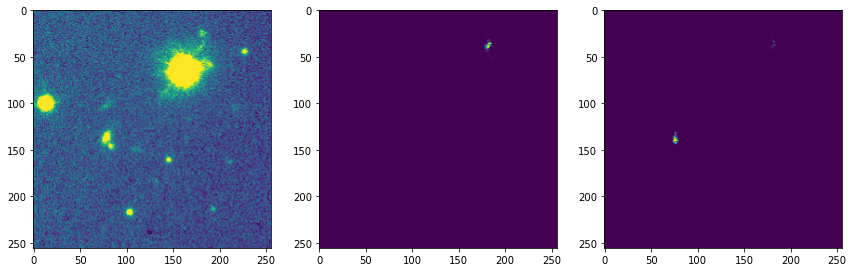

In [22]:
prediction_new(real_image_test[172,:,:])

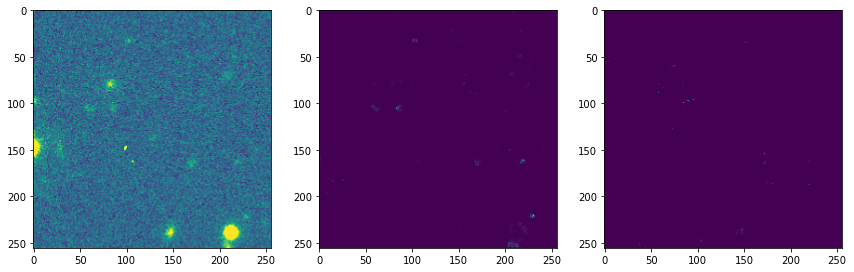

In [23]:
prediction_new(real_image_test[15,:,:])

### 5.3 Original synthetic images 

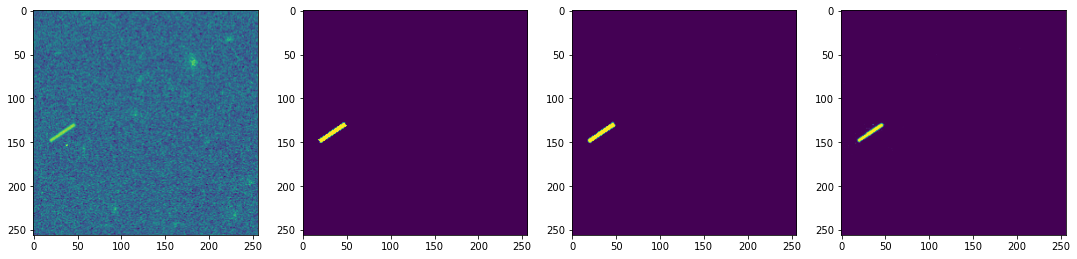

In [24]:
# Compare the performance of both models on synthetic images to see how the fine tuning change the previous task
prediction_train(3102)